In [1]:
import os
import time 
import multiprocessing as mp
import warnings
warnings.filterwarnings('ignore')

import nltk
import re
import pickle

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set_palette('Set1', 10, desat=0.75)

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 200)

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_PATH = 'data/'
NUM_CORES = 6

def apply_parallel(df, my_func):
    """
    Input: 
        df: pandas DataFrame or pandas Series
        my_func: custom function which will be apllied to df. Must accept pandas DataFrame or Series as input.
    Output: concatenated results of function application on DataFrame. Either pandas Series or pandas DataFrame.
    
    df is splitted by the number of cores and function applied to each part independetly.
    Results are concatenated and returned
    """
    df_splitted = np.array_split(df, NUM_CORES)
    pool = mp.Pool(NUM_CORES)
    result = pd.concat(pool.map(my_func, df_splitted))
    pool.close()
    pool.join()
    return result

In [3]:
data = pd.concat([pd.read_csv(os.path.join(DATA_PATH, 'train_ids.csv')), 
                  pd.read_csv(os.path.join(DATA_PATH, 'train_preprocessed.csv'), sep=';', usecols=['target'])]
                 ,axis=1)
kagg = pd.read_csv(os.path.join(DATA_PATH, 'test_ids.csv'))

In [4]:
data.head()

,qid1,qid2,graph_id,target
0,1,2,1,0
1,3,4,3,0
2,5,6,5,0
3,7,8,7,0
4,9,10,9,0


# Count features

In [5]:
# Distionaries with qid as key and it's number of occurences as value. 
# First dict is for first quesitons only, the second - only for second questions.
q1_cnts = pd.concat([data.qid1, kagg.qid1]).value_counts().to_dict()
q2_cnts = pd.concat([data.qid2, kagg.qid2]).value_counts().to_dict()

In [6]:
%%time
def add_count_features(data):
    """
    Input: pd DataFrame with two columns: qid1 and qid2. Columns must contain numbers for question's ids
    Output: pd DataFrames with count features calculated
    """
    
    initial_columns_number = data.shape[1]
    
    # Total number of occurrences for each question
    data['q1_total_counts'] = data.qid1.apply(lambda qid: q1_cnts.get(qid,0) + q2_cnts.get(qid,0)) 
    data['q2_total_counts'] = data.qid2.apply(lambda qid: q1_cnts.get(qid,0) + q2_cnts.get(qid,0)) 
    
    # Sum of question occurrences for each pair
    data['sum_count'] = data["q1_total_counts"] + data["q2_total_counts"]
    
    # Each question's number of occurrences in first and second positions 
    data['q1_counts_in_q1'] = data.qid1.apply(lambda qid: q1_cnts.get(qid,0) )
    data['q1_counts_in_q2'] = data.qid1.apply(lambda qid: q2_cnts.get(qid,0) )
    data['q2_counts_in_q1'] = data.qid2.apply(lambda qid: q1_cnts.get(qid,0) )
    data['q2_counts_in_q2'] = data.qid2.apply(lambda qid: q2_cnts.get(qid,0) )
    
    # How often first question in pair occured on position of second question and vice versa
    data['q1_in_q2_share'] = data["q1_counts_in_q2"] / data["q1_counts_in_q1"]
    data['q2_in_q1_share'] = data["q2_counts_in_q1"] / data["q2_counts_in_q2"]

    count_features = data.columns[initial_columns_number:]
    return data[count_features]
    
initial_columns_number = data.shape[1]

data = pd.concat((data, 
                  apply_parallel(data[['qid1', 'qid2']], add_count_features)),
                  axis=1)
kagg = pd.concat((kagg, 
                  apply_parallel(kagg[['qid1', 'qid2']], add_count_features)), 
                  axis=1)

count_features = list(data.columns[initial_columns_number:])

CPU times: user 511 ms, sys: 1.39 s, total: 1.9 s
Wall time: 7.6 s


In [7]:
print (data[['target']+count_features].corr(method='spearman').iloc[0])

target             1.000000
q1_total_counts    0.354381
q2_total_counts    0.381026
sum_count          0.331635
q1_counts_in_q1    0.312566
q1_counts_in_q2    0.334984
q2_counts_in_q1    0.312547
q2_counts_in_q2    0.355853
q1_in_q2_share     0.287267
q2_in_q1_share     0.267589
Name: target, dtype: float64


# Question's neighbors

In [8]:
%%time
# Creating pd DataFrame, that contains all qid pairs from train and test twice: in original order and 
# with q1 and q2 switched. This switching is needed because we will aggregate only by qid1 field.

all_qids = pd.concat([data[['qid1', 'qid2']], kagg[['qid1', 'qid2']]], axis=0)

mirrored_all_qids = pd.DataFrame()
mirrored_all_qids['qid1'] = all_qids.qid2
mirrored_all_qids['qid2'] = all_qids.qid1

all_qids = pd.concat([all_qids, mirrored_all_qids], axis=0)
del mirrored_all_qids


# Constructing dictionary, that for every question id returns a list of question ids,
# that have been seen with key quesiton id, in other words - adjacent questions in graph.

# After agg function we have pd DataFrame with two columns: 
# 'qid1' - unique 'qid1's 
# 'qid2' - list of qids, that have been seen with qid1 in the whole dataset
qid_adjacent_dict = (all_qids
                      .groupby('qid1', as_index=False)
                      .agg(lambda x: list(x))
                      .set_index('qid1')
                      .qid2
                      .to_dict()
                     )

CPU times: user 4min 36s, sys: 3.15 s, total: 4min 39s
Wall time: 4min 40s


In [9]:
print (qid_adjacent_dict[37]) # example

[38, 27516, 17811, 19621, 88633, 12639, 6551, 18296, 17507, 26052, 1358, 33411, 21713, 17506, 4951, 1357, 17258, 47013, 556276, 552625, 226479, 797836, 546204]


Let's create for each question list of it's neighbors. The closest neigbors are the questions, that have been seen in pair with question in consideration. Let's call these neighbors level 1 neigbors. Level 2 neighbors are questions, that have been seen with any quesitons from 1 level neighbors and so on. 

In [10]:
%%time
def add_level_neighbors(qids):
    """
    input: questions ids in pd Series
    return: pd Series of question neighbors (certain level)
    """
    
    def get_level_neighbors(qid):
        """
        input: question id (int)
        return: list of question neighbors for this question id
        Uses global variable LEVEL. If equals to 1 - only conneted questions are added to neighbor list. 
        If equals to 2 - added questions, that are conneted to conneted questions to original one.
        """
        neighbors = qid_adjacent_dict[qid]
        for i in range(1, int(LEVEL)):
            neighbors = flatten(qid_adjacent_dict[neighbor_id] for neighbor_id in neighbors)
        return list(neighbors)
    
    return qids.apply(get_level_neighbors)
 
# For each question in pair add it's neighbors in form of a string. 
LEVELS = ['1', '2']
for LEVEL in LEVELS:
    t_start = time.time()
    
    data['qid1_nbr_'+LEVEL] = apply_parallel(data.qid1, add_level_neighbors)
    data['qid2_nbr_'+LEVEL] = apply_parallel(data.qid2, add_level_neighbors)
    
    kagg['qid1_nbr_'+LEVEL] = apply_parallel(kagg.qid1, add_level_neighbors)
    kagg['qid2_nbr_'+LEVEL] = apply_parallel(kagg.qid2, add_level_neighbors)
    
    print ('Level {} is done in {} minutes \n'.format(LEVEL, round((time.time()-t_start)/60,1) ))

Level 1 is done in 0.7 minutes 

Level 2 is done in 21.5 minutes 

CPU times: user 55.8 s, sys: 1min 27s, total: 2min 22s
Wall time: 22min 11s


# Jaccard and cosine distances between lists of neighbors for each pair

In [11]:
%%time
def jaccard_distance(neighbors1, neighbors2):
    return len(set(neighbors1).intersection(set(neighbors2))) / len(set(neighbors1+neighbors2))

for LEVEL in LEVELS:
    data['jaccard_dist_nbr_'+LEVEL] = data.apply(lambda row: jaccard_distance(row['qid1_nbr_'+LEVEL], 
                                                                              row['qid2_nbr_'+LEVEL]), axis=1)
    kagg['jaccard_dist_nbr_'+LEVEL] = kagg.apply(lambda row: jaccard_distance(row['qid1_nbr_'+LEVEL], 
                                                                              row['qid2_nbr_'+LEVEL]), axis=1)

CPU times: user 4min 15s, sys: 14.5 s, total: 4min 29s
Wall time: 4min 37s


In [12]:
%%time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

def apply_parallel_sparse(DF, my_func):
    """
    Input: 
        DF: scipy sparse matrix
        my_func: custom function which will be apllied to DF. Must accept scipy sparse matrix and return a list.
    Output: concatenated results of function application on DataFrame. Either pandas Series or pandas DataFrame.
    
    DF is splitted by the number of cores and function applied to each part independetly.
    Results are combined in one list and returned
    """
    
    # Get split indices for DF to split on batches with (total_rows/NUM_CORES) rows each
    total_rows = DF.shape[0]
    split_indices = []
    for i in range(NUM_CORES):
        split_on = (int(total_rows/NUM_CORES)*i)
        split_indices.append(split_on)
    split_indices.append(total_rows)
    
    # Replace input matrix with list of NUM_CORES matricies
    DF = [DF[split_indices[i]:split_indices[i+1]] for i in range(NUM_CORES)]
    
    # Apply my_func to each element of a DF list (sparse matricies) and construct final results list
    res = []
    pool = mp.Pool(NUM_CORES)
    for part_res in pool.map(my_func, DF):
        res+=part_res
    pool.close()
    pool.join()
    return res

def efficient_hstack_csr(csr_matrices, batch_size=1e5):
    """
    Input: 
        csr_matrices: list of csr sparse matrices to be hstacked. All must have same row number.
        batch_size: int, number of rows to hstack per batch. The lower the batch, the lower the memory footprint.
        Recommended batch size 10-200K.
    Output: essentially just sparse.hstack(csr_matrices, format='csr'), but much more efficient
    
    Hstack operation works ok only on csc matrices or small csr matrices, so we can't apply it on tfidf ouputs as is. 
    Therefore we will hstack small batches with each other and after that vstack all resulting batches. Vstack works
    the best with csr format, as we need. 
    """
    
    batches = []
    batch_size = int(batch_size) # convert float to int in case if passed like 1e5
    for i in range(0, csr_matrices[0].shape[0], batch_size):
        lower_bound = i
        upper_bound = min(i+batch_size, csr_matrices[0].shape[0])
        batches.append(sparse.hstack([csr_matrix[lower_bound:upper_bound] for csr_matrix in csr_matrices]
                                     , format='csr'))
    
    return sparse.vstack(batches, format='csr')


def cosine_sim(DF):
    """
    Input: 
        DF: scipy sparse matrix. Must be constracted preliminarily from two sparse matricies with the 
        same number of columns. Each of sparse matrices - tfidf sparse representation of one of the questions.
    Output: list of cosine similarities between two halves of DF
    
    Usage example:
    tf_q1 = tfidf.transform(train['q1_src'])
    tf_q2 = tfidf.transform(train['q2_src'])
    train['cosine_similarities'] = cosine_sim(efficient_hstack_csr(tf_q1, tf_q2, 1e5))
    """
    
    split_halves_on = int(DF.shape[1]/2) # Get number of columns in each part
    df1 = DF[:, :split_halves_on]
    df2 = DF[:, split_halves_on:]
    return [cosine_similarity(df1[i], df2[i])[0][0] for i in range(df1.shape[0])] 


for LEVEL in LEVELS:    
    # Get list of all neighbors. String map is needed since question ids are stored in lists as integers
    corpus = (data['qid1_nbr_'+LEVEL].apply(lambda x: ' '.join(map(str, x))).tolist()
             +data['qid2_nbr_'+LEVEL].apply(lambda x: ' '.join(map(str, x))).tolist()
             +kagg['qid1_nbr_'+LEVEL].apply(lambda x: ' '.join(map(str, x))).tolist() 
             +kagg['qid2_nbr_'+LEVEL].apply(lambda x: ' '.join(map(str, x))).tolist()
             )
    vectorizer = CountVectorizer().fit(corpus) 
    del corpus

    t_start = time.time()
    tf_q1 = vectorizer.transform(data['qid1_nbr_'+LEVEL].apply(lambda x: ' '.join(map(str, x))))
    tf_q2 = vectorizer.transform(data['qid2_nbr_'+LEVEL].apply(lambda x: ' '.join(map(str, x))))
    data['cosine_nbr_'+LEVEL] = apply_parallel_sparse(efficient_hstack_csr([tf_q1, tf_q2]), cosine_sim)
    print ('Level {} for train is done in {} minutes \n'.format(LEVEL, round((time.time()-t_start)/60,1) ))
    
    t_start = time.time()
    tf_q1 = vectorizer.transform(kagg['qid1_nbr_'+LEVEL].apply(lambda x: ' '.join(map(str, x))))
    tf_q2 = vectorizer.transform(kagg['qid2_nbr_'+LEVEL].apply(lambda x: ' '.join(map(str, x))))
    kagg['cosine_nbr_'+LEVEL] = apply_parallel_sparse(efficient_hstack_csr([tf_q1, tf_q2]), cosine_sim)
    print ('Level {} for test is done in {} minutes \n'.format(LEVEL, round((time.time()-t_start)/60,1) ))
    
del tf_q1, tf_q2

Level 1 for train is done in 22.6 minutes 

Level 1 for test is done in 137.2 minutes 

Level 2 for train is done in 26.1 minutes 

Level 2 for test is done in 157.3 minutes 

CPU times: user 45min 5s, sys: 2min 14s, total: 47min 20s
Wall time: 6h 7min 3s


# Counts statistics on lists of neighbors

In [13]:
%%time
def add_counts_on_neighbors(data, LEVEL):
    """
    Input: pandas DataFrame. Must have two columns, corresponding to two question's neighbors lists
    Output: pd DataFrames with count statistics on neighbors calculated
    """
    
    data['q1_nbr_cnts'] = data['qid1_nbr_'+LEVEL].apply(lambda nbrs: [q1_cnts.get(qid,0)+q2_cnts.get(qid,0) for qid in nbrs])
    data['q2_nbr_cnts'] = data['qid2_nbr_'+LEVEL].apply(lambda nbrs: [q1_cnts.get(qid,0)+q2_cnts.get(qid,0) for qid in nbrs])
    
    data['q1_nbr_cnts_min_'+LEVEL] = data.q1_nbr_cnts.apply(lambda x: np.min(x))
    data['q1_nbr_cnts_max_'+LEVEL] = data.q1_nbr_cnts.apply(lambda x: np.max(x))
    data['q1_nbr_cnts_avg_'+LEVEL] = data.q1_nbr_cnts.apply(lambda x: np.mean(x))
    data['q1_nbr_cnts_med_'+LEVEL] = data.q1_nbr_cnts.apply(lambda x: np.median(x))

    data['q2_nbr_cnts_min_'+LEVEL] = data.q2_nbr_cnts.apply(lambda x: np.min(x))
    data['q2_nbr_cnts_max_'+LEVEL] = data.q2_nbr_cnts.apply(lambda x: np.max(x))
    data['q2_nbr_cnts_avg_'+LEVEL] = data.q2_nbr_cnts.apply(lambda x: np.mean(x))
    data['q2_nbr_cnts_med_'+LEVEL] = data.q2_nbr_cnts.apply(lambda x: np.median(x))
    
    data['q12_nbr_cnts_min_'+LEVEL] = data.apply(lambda row: np.min   (row.q1_nbr_cnts + row.q2_nbr_cnts), axis=1)
    data['q12_nbr_cnts_max_'+LEVEL] = data.apply(lambda row: np.max   (row.q1_nbr_cnts + row.q2_nbr_cnts), axis=1)
    data['q12_nbr_cnts_avg_'+LEVEL] = data.apply(lambda row: np.mean  (row.q1_nbr_cnts + row.q2_nbr_cnts), axis=1)
    data['q12_nbr_cnts_med_'+LEVEL] = data.apply(lambda row: np.median(row.q1_nbr_cnts + row.q2_nbr_cnts), axis=1)
    
    data.drop(['q1_nbr_cnts', 'q2_nbr_cnts'], axis=1, inplace=True)
    return data

for LEVEL in LEVELS:
    t_start = time.time()
    data = add_counts_on_neighbors(data, LEVEL)
    print ('Level {} is done for train in {} minutes \n'.format(LEVEL, round((time.time()-t_start)/60,1) ))
    
    t_start = time.time()
    kagg = add_counts_on_neighbors(kagg, LEVEL)
    print ('Level {} is done for test  in {} minutes \n'.format(LEVEL, round((time.time()-t_start)/60,1) ))

Level 1 is done for train in 3.4 minutes 

Level 1 is done for test  in 16.1 minutes 

Level 2 is done for train in 4.3 minutes 

Level 2 is done for test  in 33.1 minutes 

CPU times: user 46min 42s, sys: 6min 55s, total: 53min 38s
Wall time: 56min 47s


# Glance at feature correlations

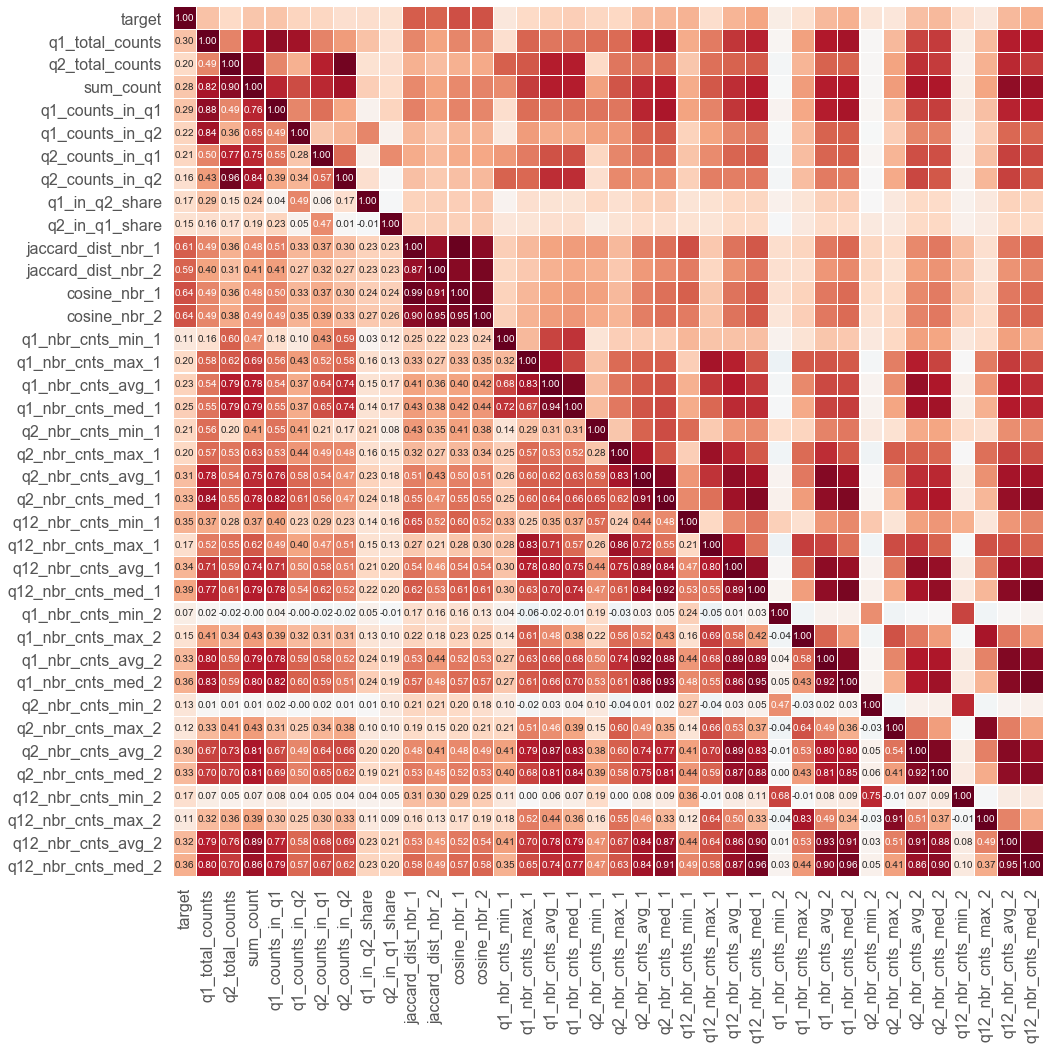

In [14]:
not_features = ['qid1', 'qid2', 'graph_id', 'target', 
                'qid1_nbr_1', 'qid2_nbr_1', 'qid1_nbr_2', 'qid2_nbr_2']
features = [col for col in data.columns if col not in not_features]

plt.figure(figsize=(16,16))

corr_matrix = data[['target']+features].corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask, 1)] = True
sns.heatmap(corr_matrix, square=True, cbar=False)
sns.heatmap(corr_matrix, square=True, cbar=False, mask=mask, annot=True, 
            fmt='.2f', annot_kws={'size':10}, linewidths=0.25)

plt.show()

We can clearly see that we have many identical features and many features with no predictive power. We will deal with them in notebook **7_features_and_model_selection**

# Prune the features

Since there are fake question in test dataframe and the non-nlp features based on quesiton counts and graph neighbors, we can expect, that test non-nlp features distributions may be different from the train one. Also there are possibly outliers in train data, so we will replace them with 99.99% train percentile. Let's plot original distributions on the left graphs, and truncated to 99.99% percentile on the right

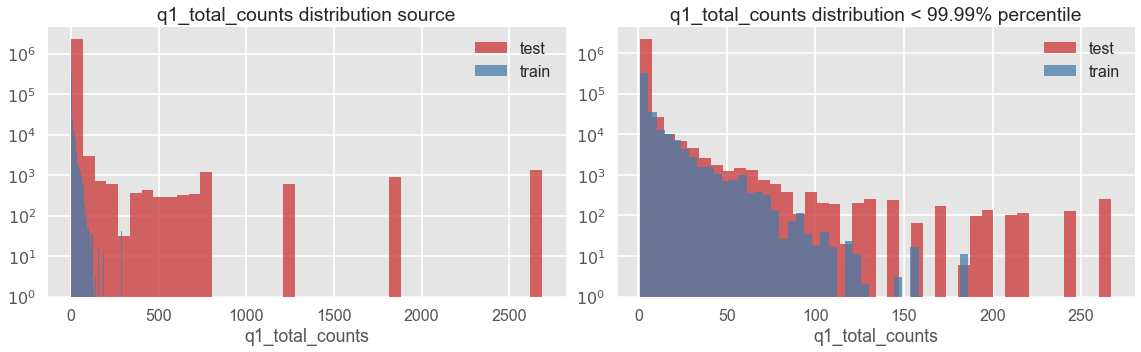

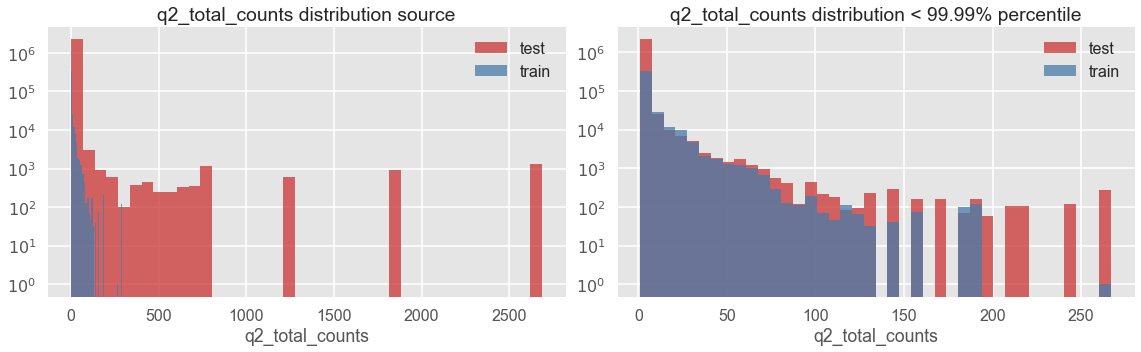

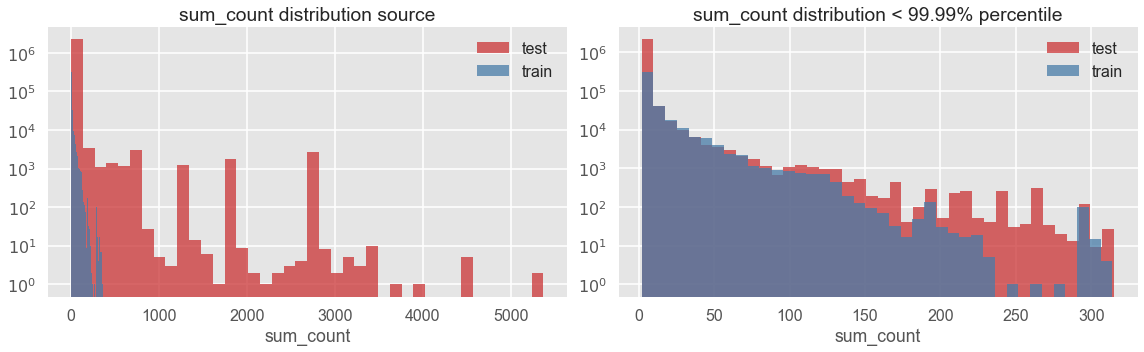

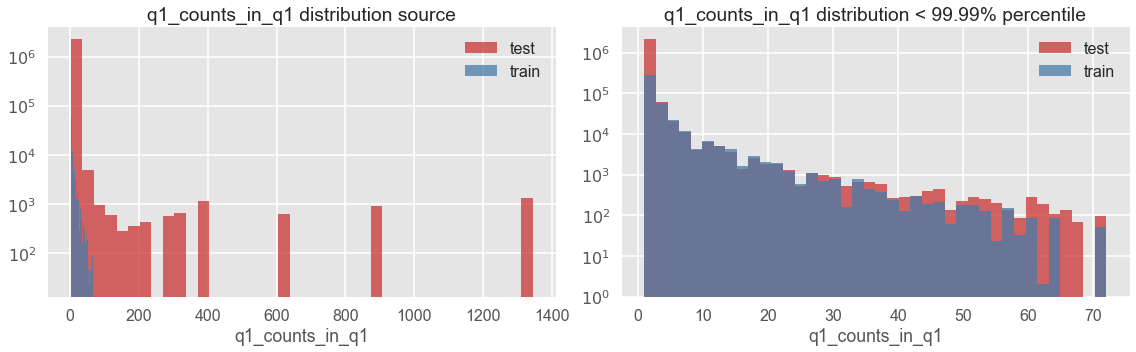

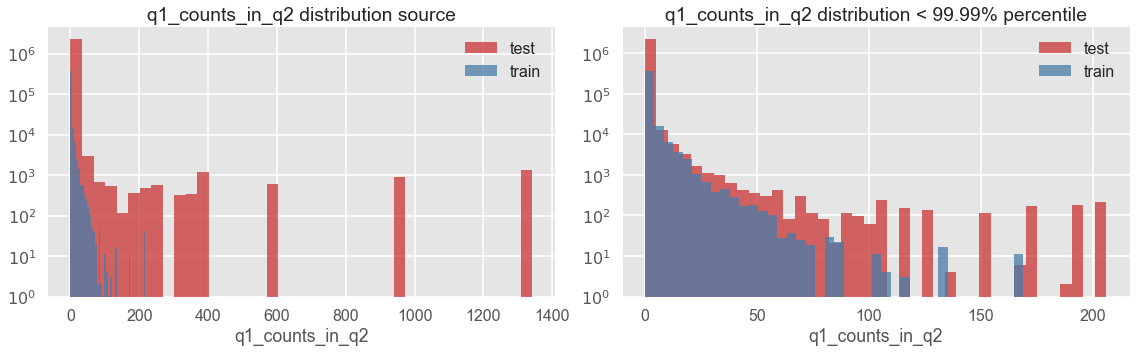

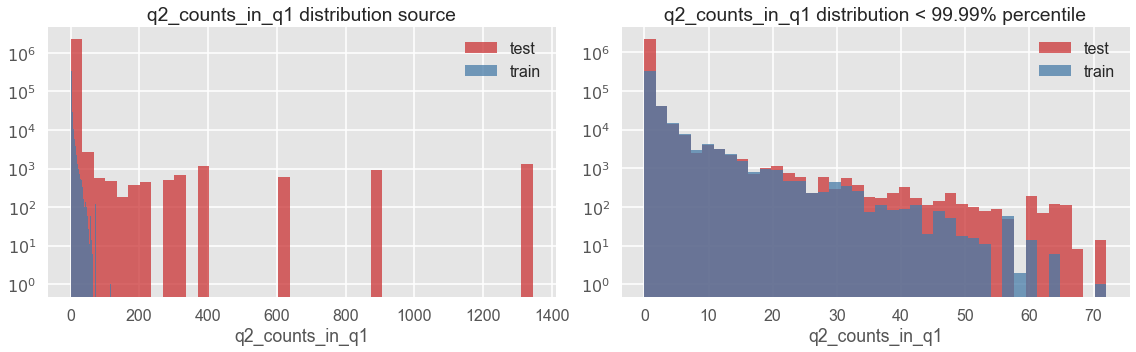

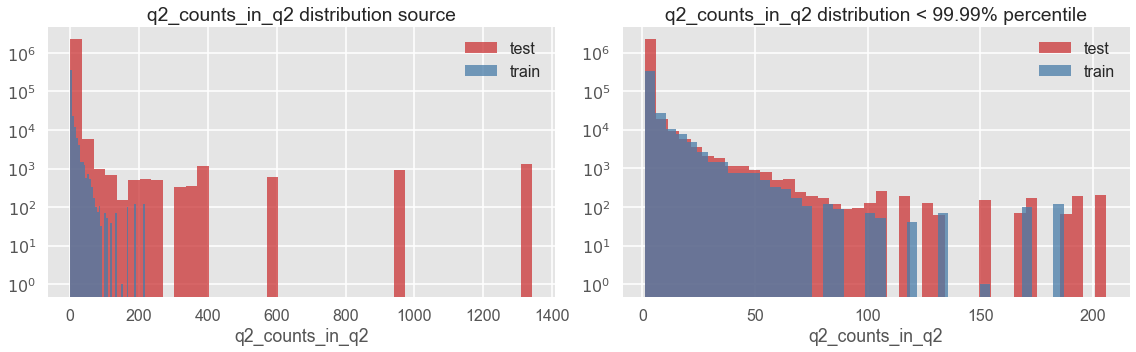

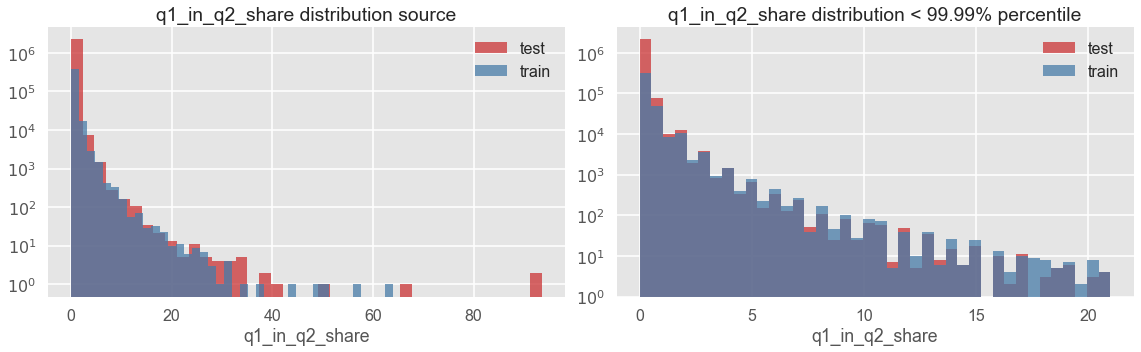

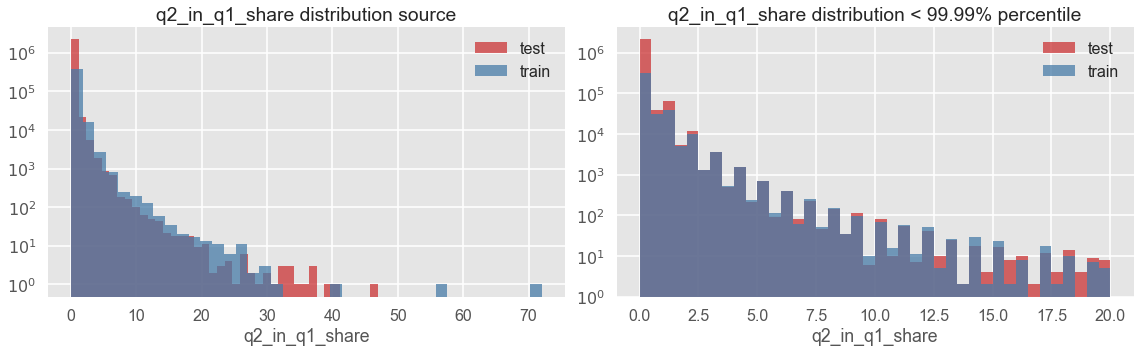

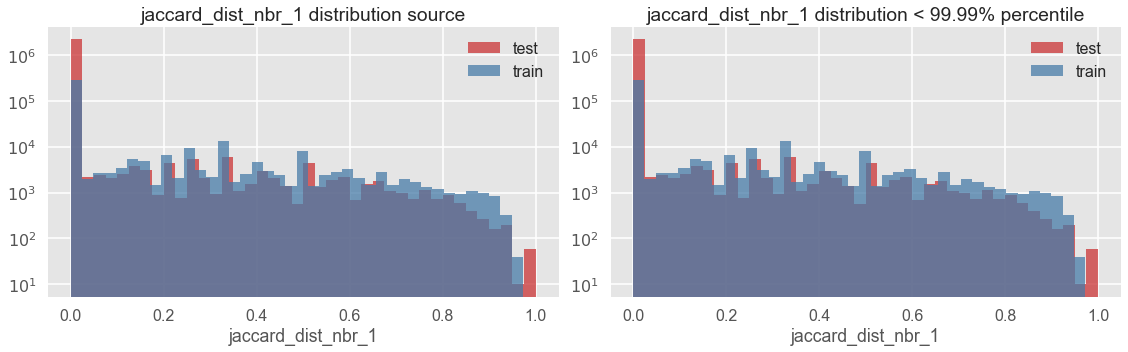

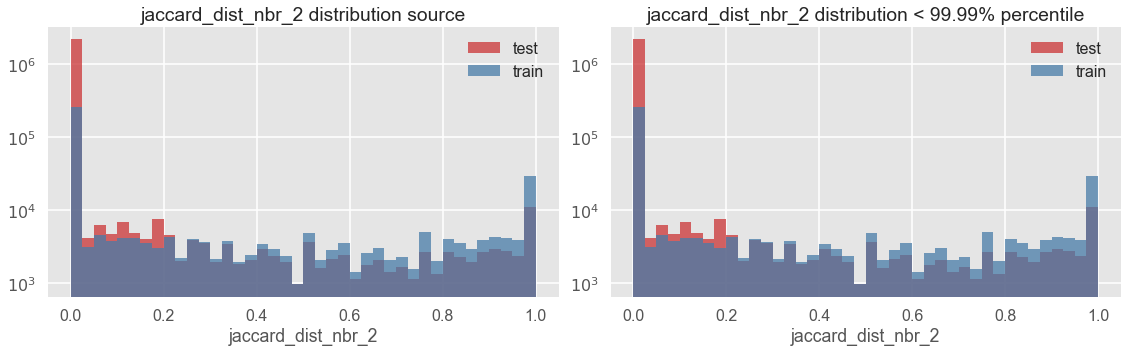

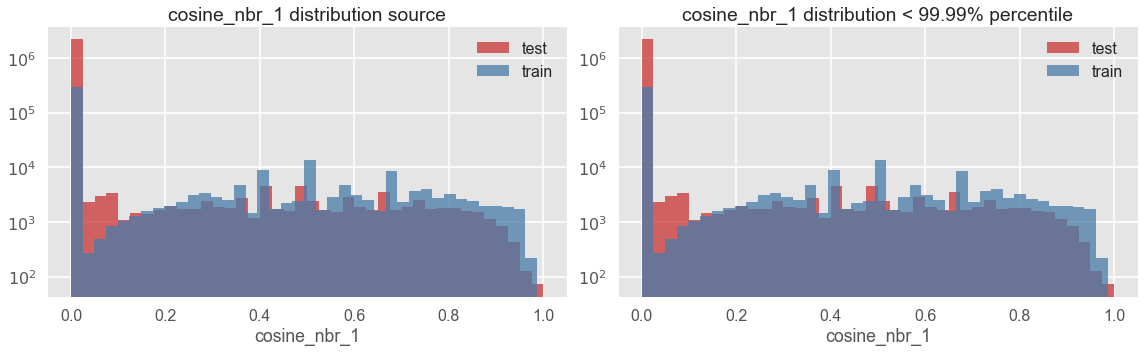

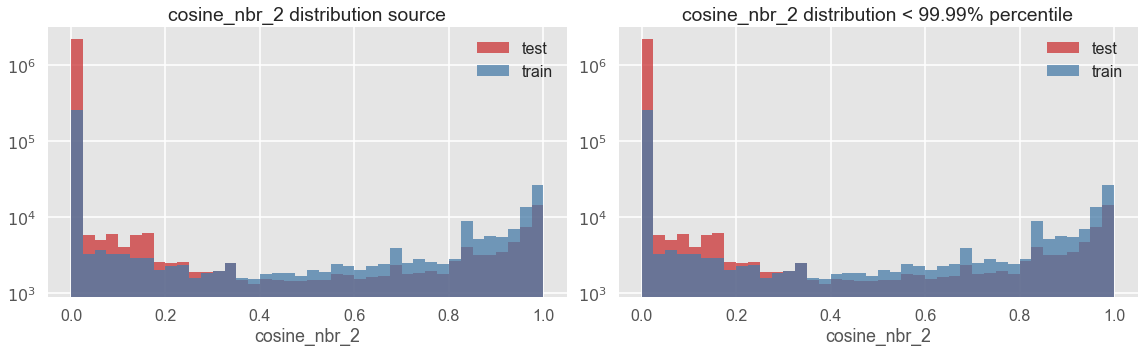

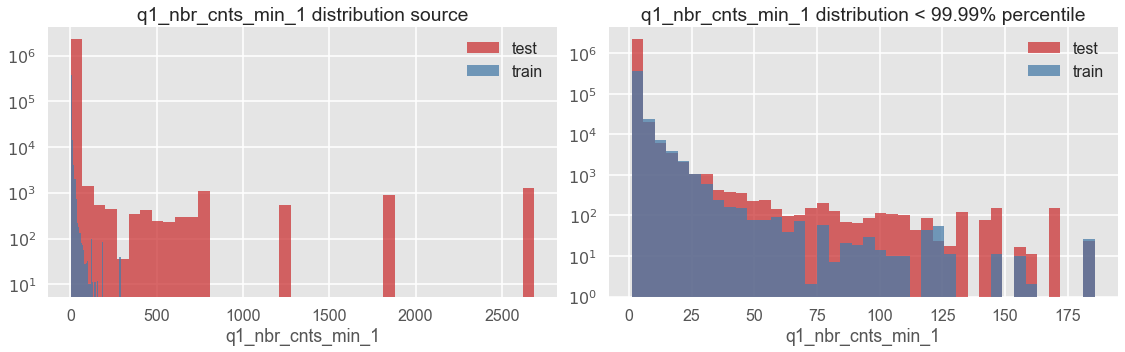

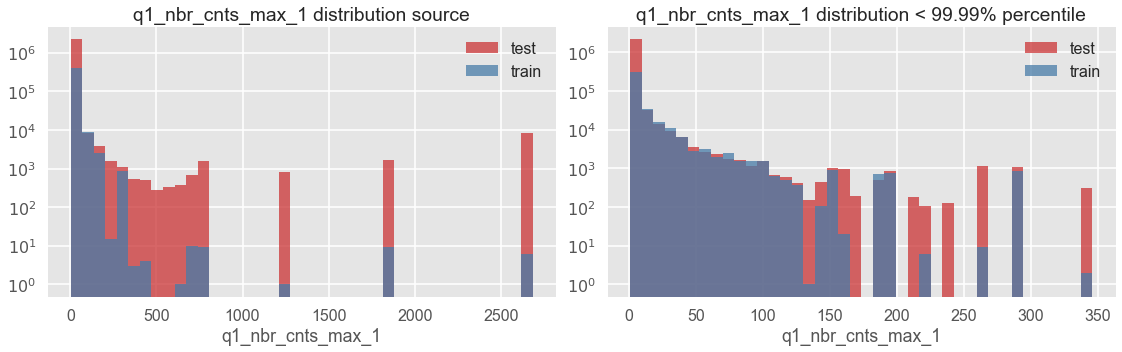

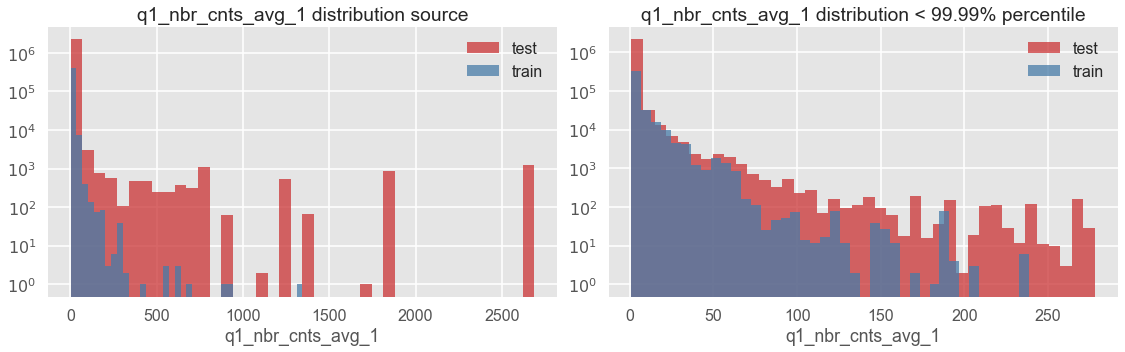

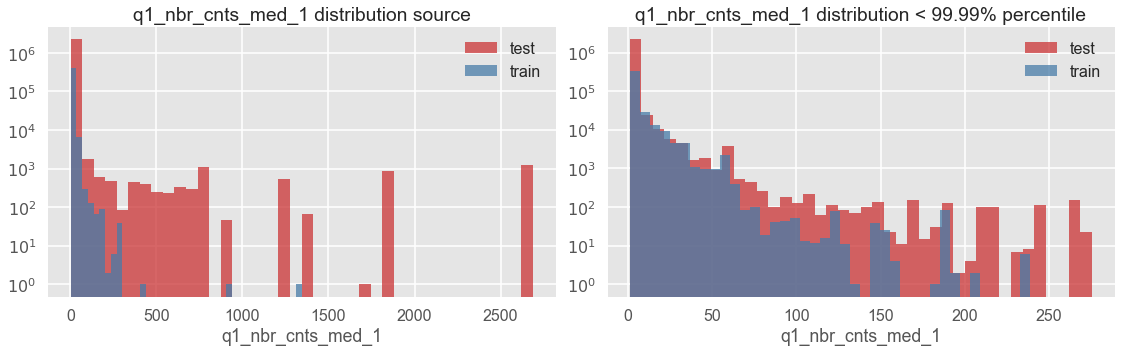

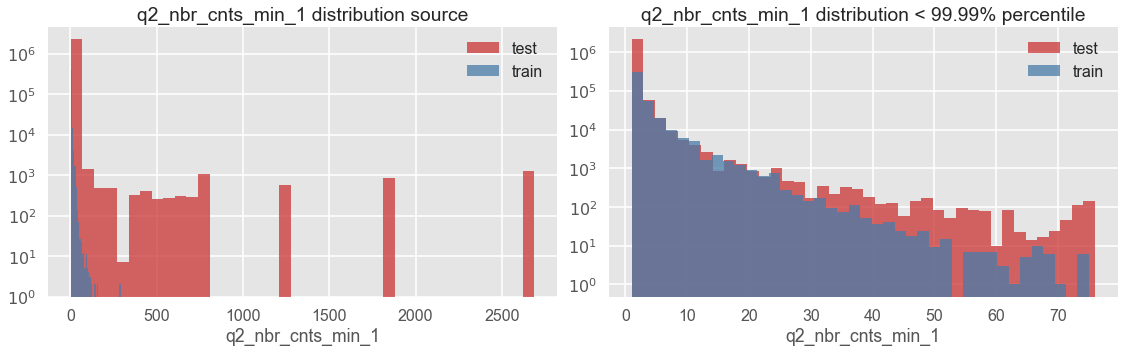

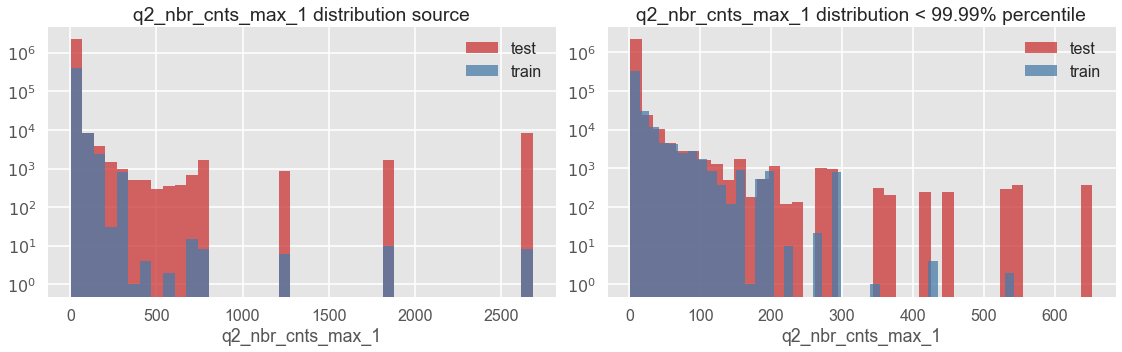

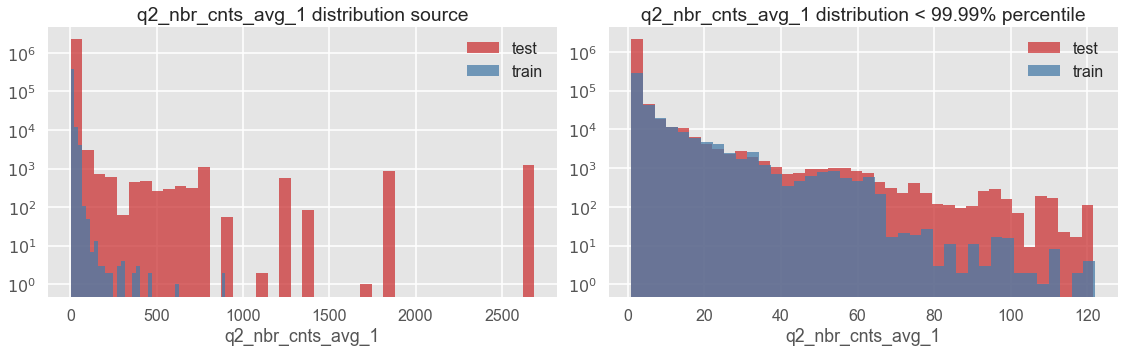

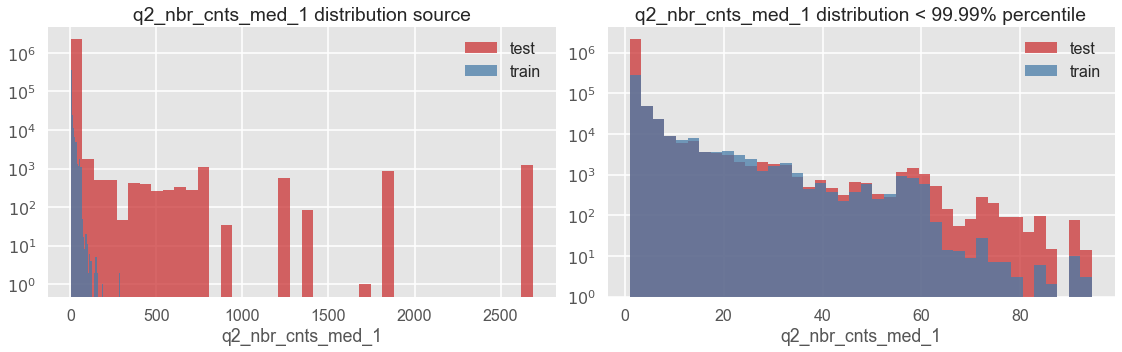

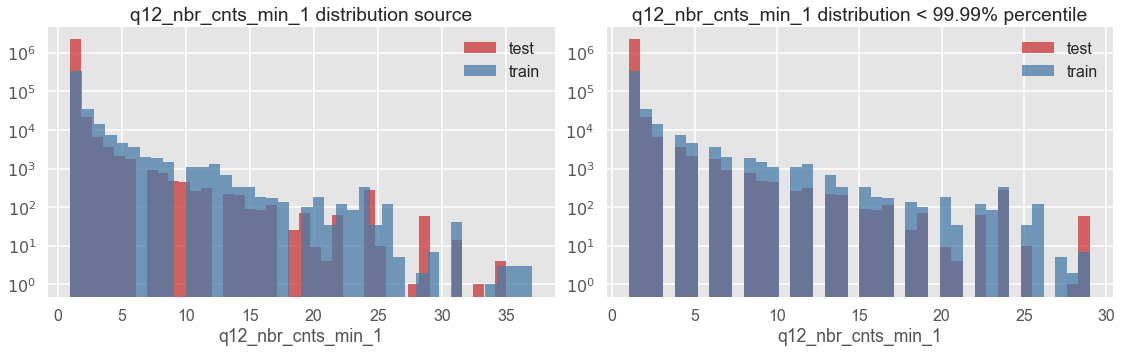

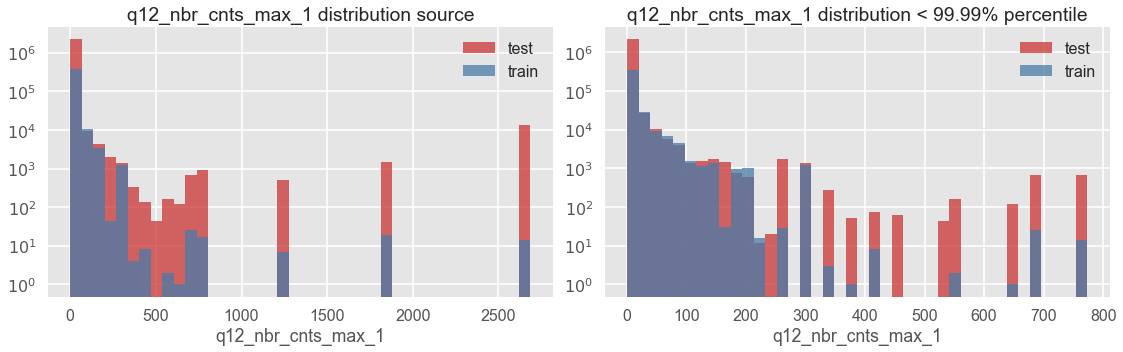

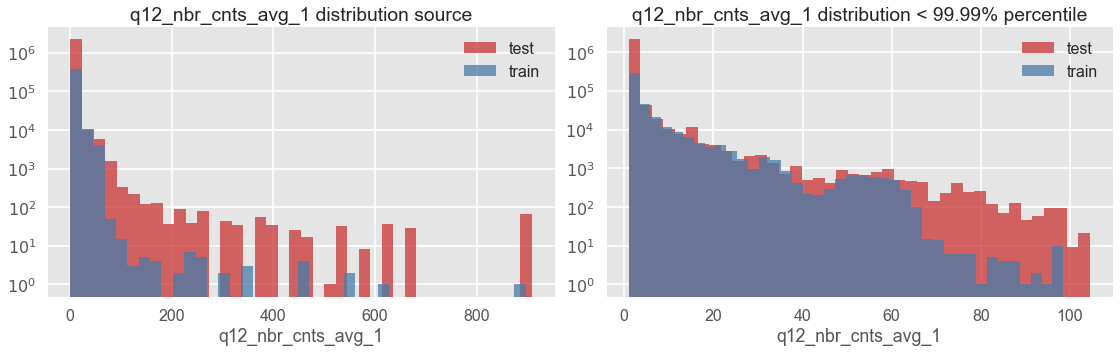

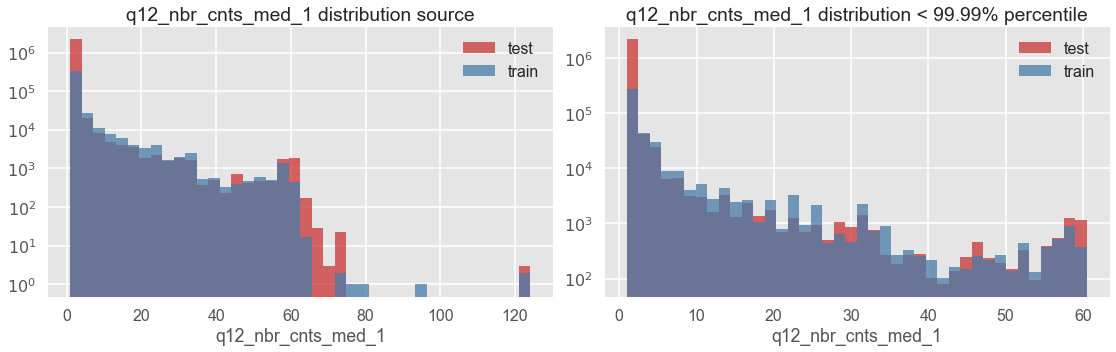

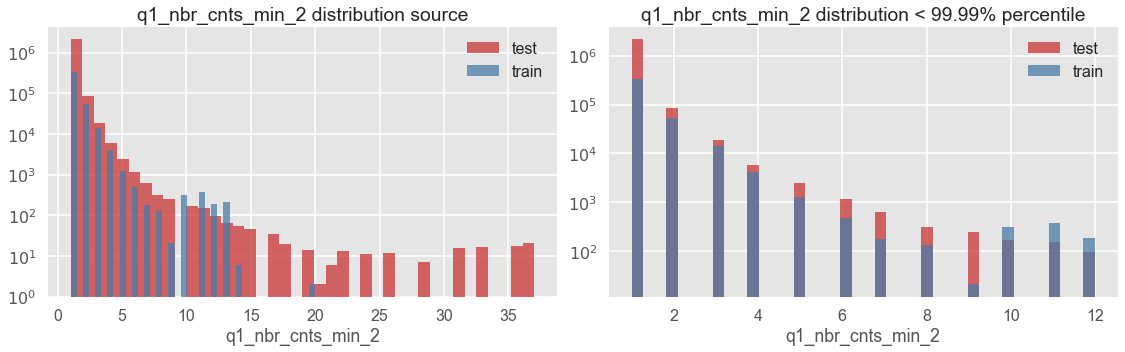

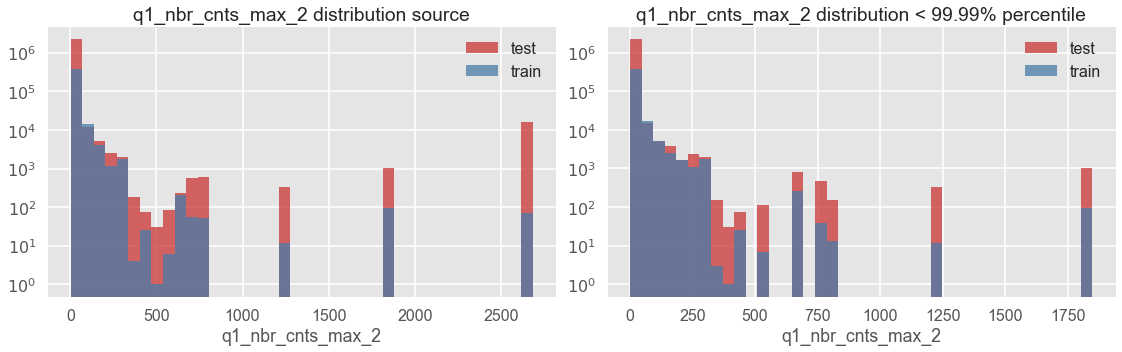

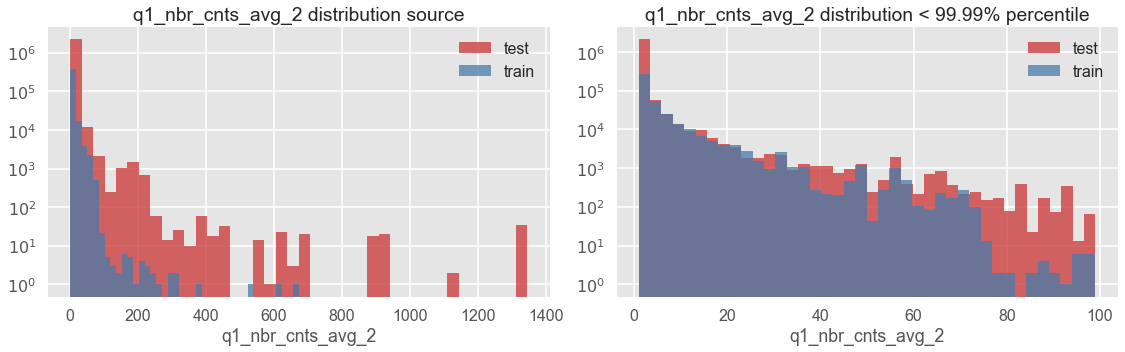

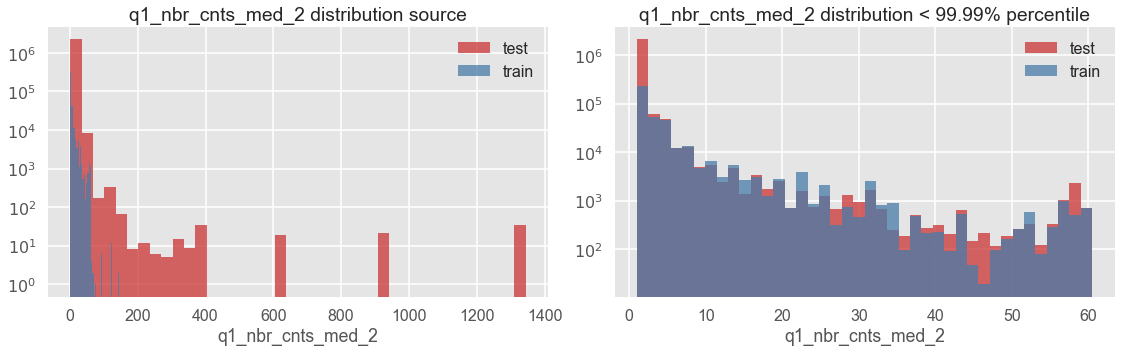

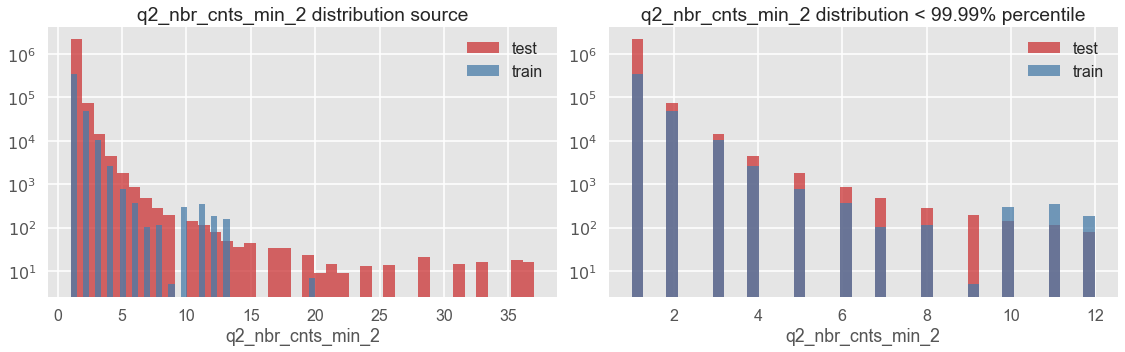

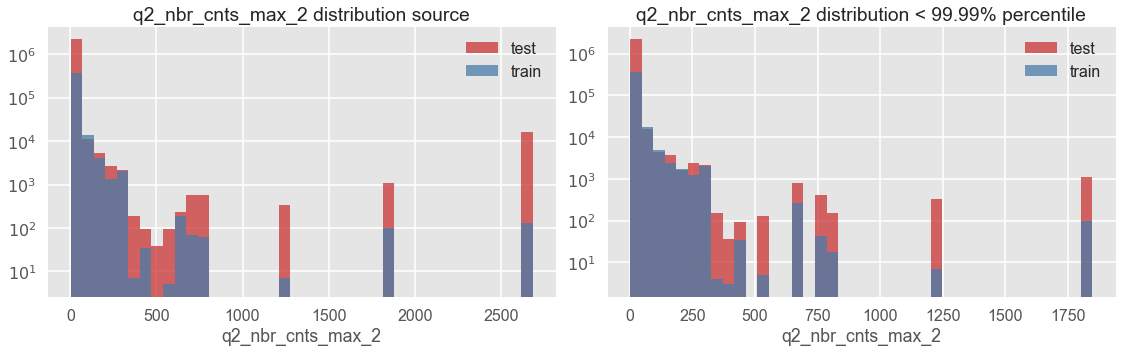

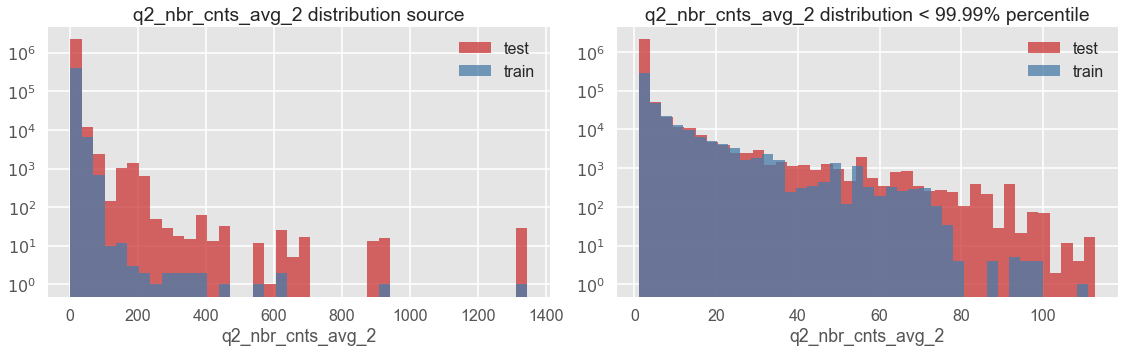

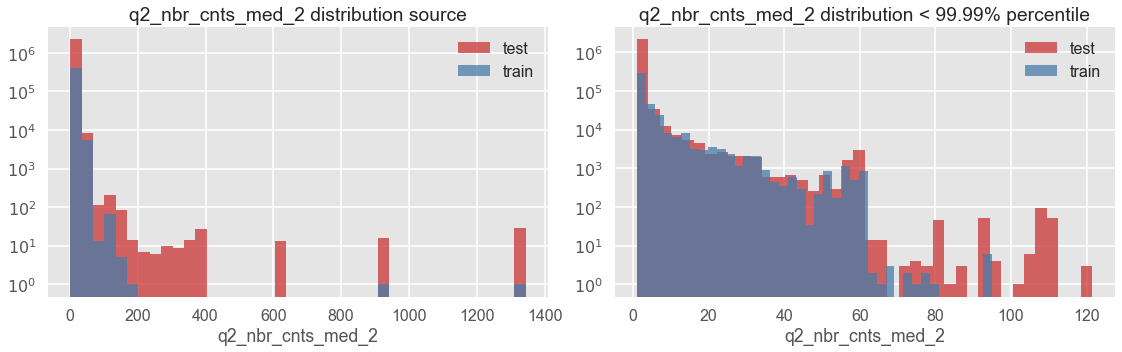

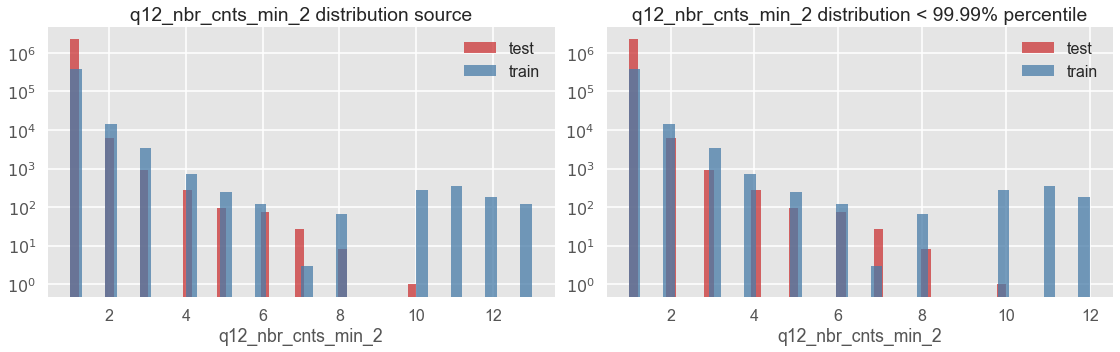

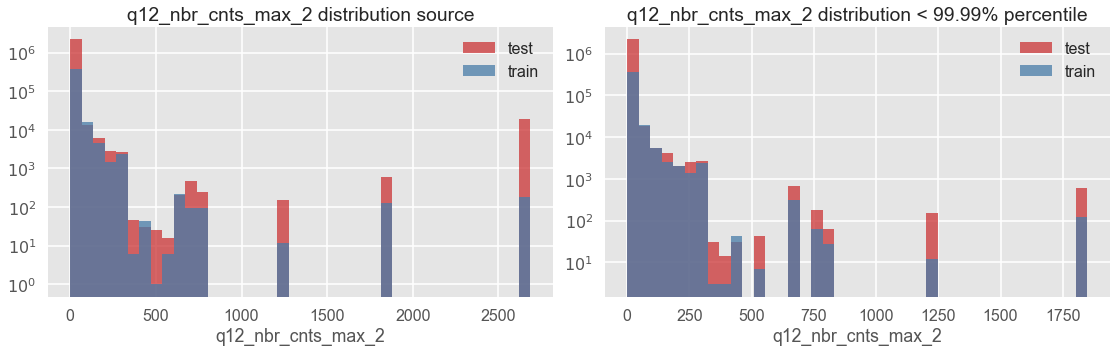

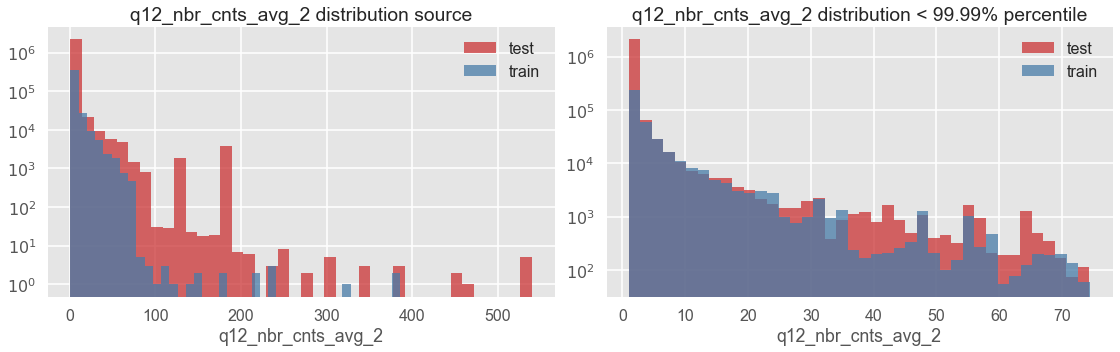

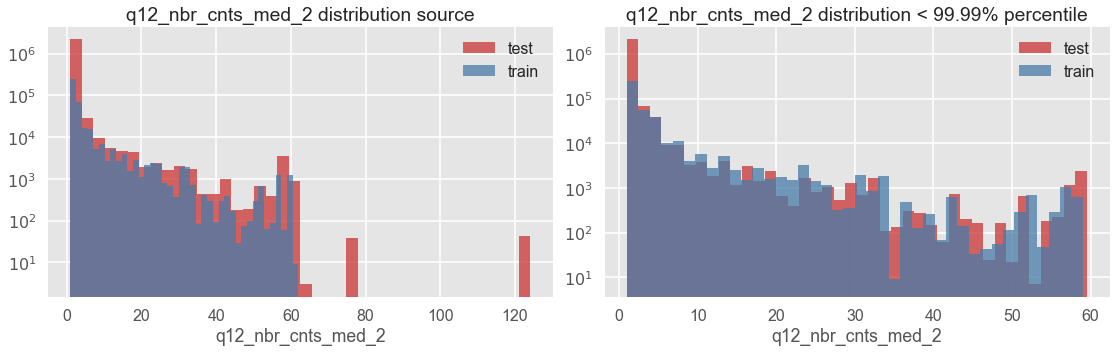

In [17]:
for feature in features:
    percentile_max = np.percentile(data[feature], 99.99)
    percentile_90  = np.percentile(data[feature], 90.0)  
    
    plt.figure(figsize=(16,5))
           
    plt.subplot(1,2,1)
    plt.title(feature +' distribution source')
    plt.hist(kagg[feature], bins=40, alpha=0.75, label='test')
    plt.hist(data[feature], bins=40, alpha=0.75, label='train')
    plt.legend()
    plt.yscale('log')
    plt.xlabel(feature)
    
    # Don't prune features, that are not extremely skewed 
    if percentile_max/percentile_90 < 5:
        percentile_max = data[feature].max() + 1
        
    plt.subplot(1,2,2)
    plt.title(feature +' distribution < 99.99% percentile')
    plt.hist(kagg[kagg[feature]<percentile_max][feature], bins=40, alpha=0.75, label='test')
    plt.hist(data[data[feature]<percentile_max][feature], bins=40, alpha=0.75, label='train')
    plt.legend()
    plt.yscale('log')
    plt.xlabel(feature)
    
    plt.tight_layout()
    plt.show()

Obviosly, distributions for pruned features looks way better. Let's prune features before saving

In [18]:
%%time
def normalize_nonnlp_features(train, test, threshold, features):
    """
    imput:
        train, test - pandas DataFrames
        threshold - float, percentile threshold to which we'll prune the outliers
        features - list of features to be pruned. Must be contained in both train and test DataFrames
    output: train, test pandas DataFrames with features pruned
    """
    for feature in features:
        percentile_90  = np.percentile(train[feature], 90.0)
        percentile_max = np.percentile(train[feature], threshold)
        
        # Only prune extremely skewed features
        if percentile_max/percentile_90 > 5:
            train[feature] = train[feature].apply(lambda x: min(x, percentile_max))
            test [feature] = test [feature].apply(lambda x: min(x, percentile_max))   
    return train, test

data, kagg = normalize_nonnlp_features(data, 
                                        kagg, 
                                        threshold=99.99, 
                                        features=features)

CPU times: user 1min 3s, sys: 3.71 s, total: 1min 6s
Wall time: 1min 7s


In [19]:
data[features].to_csv(os.path.join(DATA_PATH, 'train_nonNLP_features.csv'), index=False)
kagg[features].to_csv(os.path.join(DATA_PATH,  'test_nonNLP_features.csv'), index=False)

with open(os.path.join('data', 'nonNLP_features.pkl'), 'wb') as F:
    pickle.dump(features, F)